In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from collections import Counter

print(tf.executing_eagerly())

True


In [3]:
df = pd.read_csv('D:/Marko/MoviesSentimentAnalysis/140SentimentDataset/training.1600000.processed.noemoticon.csv',
                names = [
                    'target',
                    'id',
                    'date',
                    'flag',
                    'user',
                    'text'
                ])
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.target.unique()
# 0 - negative tweet
# 4 - positive tweet

array([0, 4], dtype=int64)

In [5]:
# we have to convert the tweets to lowercase letters for bert uncased model

df.text = [tweet.lower() for tweet in df.text]
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan i dived many times for the ball. man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Counter({0: 800000, 4: 800000})


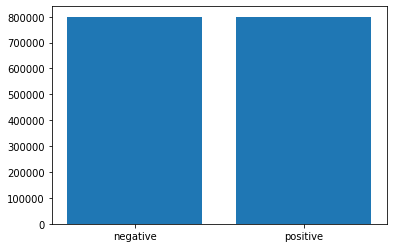

In [6]:
class_distrib = Counter(df.target)

print(class_distrib)
plt.bar(['negative', 'positive'], class_distrib.values())
plt.show()

In [7]:
sample_size = int(len(df)*0.02)
sampleDf = df.sample(sample_size, random_state=23)

x = sampleDf.text
y = sampleDf.target
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    stratify=y,
    random_state=32
)

print(sampleDf.shape)
sampleDf.head()

(32000, 6)


,target,id,date,flag,user,text
1055148,4,1962159448,Fri May 29 10:36:54 PDT 2009,NO_QUERY,starchild24,yesterday was a fun day i love my work.
205169,0,1972807026,Sat May 30 09:55:30 PDT 2009,NO_QUERY,soundkitchen,swfwheel ???? js ? externalinterface ?????????...
214746,0,1975307423,Sat May 30 14:53:05 PDT 2009,NO_QUERY,Desibeez,"@julioanta, i could of sworn it was otown, ugh..."
367135,0,2049116589,Fri Jun 05 16:19:26 PDT 2009,NO_QUERY,ryanwalker19,awwww maddy has gone
985037,4,1834438053,Mon May 18 02:56:10 PDT 2009,NO_QUERY,_nataliee,i guess i should feel special that alfie nearl...


[Counter({0: 16014, 4: 15986}), Counter({0: 12811, 4: 12789}), Counter({0: 3203, 4: 3197})]


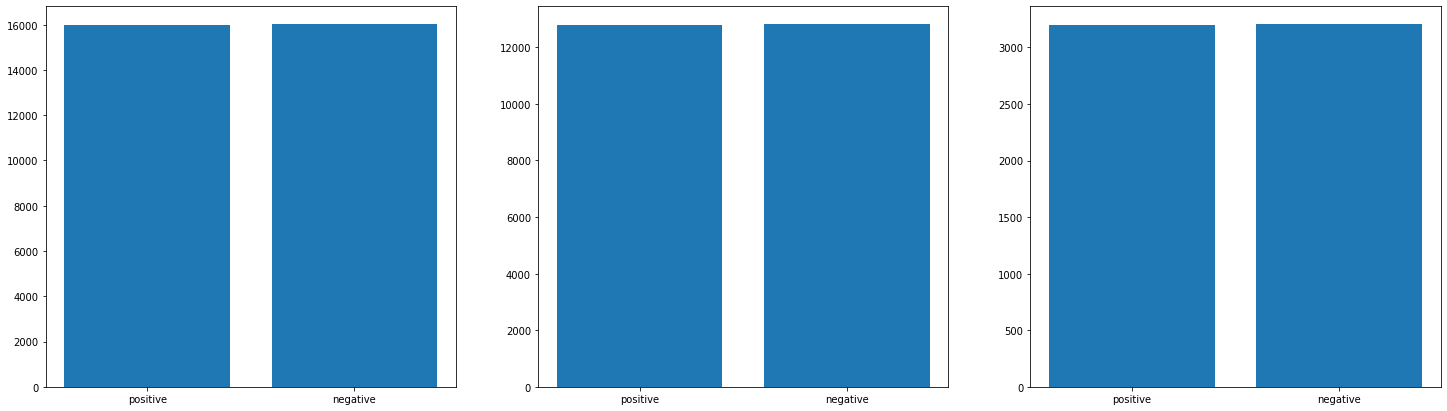

In [8]:
plt_data = [Counter(y), Counter(y_train), Counter(y_test)]
print(plt_data)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))

for data, ax in zip(plt_data, axes):
    ax.bar(['positive', 'negative'], data.values())
    
plt.show()

In [9]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

print("Encoded y_train size", len(encoded_y_train))
print(encoded_y_train)

print("Dummy y_train size", len(dummy_y_train))
print(dummy_y_train)

Encoded y_train size 25600
[1 0 1 ... 0 0 0]
Dummy y_train size 25600
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [10]:
encoder_fname = 'twitter_classes.npy'
np.save(encoder_fname, encoder.classes_)

In [11]:
loaded_model = hub.load("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/2")
bert_layer = hub.KerasLayer(loaded_model, trainable=True)

In [12]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
print("Path to locally saved vocabulary:", vocab_file)
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
print("Is the text lowercased before training the model?", do_lower_case)

Path to locally saved vocabulary: b'C:\\Users\\Dell\\AppData\\Local\\Temp\\tfhub_modules\\821b847cbc14f7de954585332dddc61bb2d629e3\\assets\\vocab.txt'
Is the text lowercased before training the model? True


In [13]:
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [16]:
def encode_names(n):
    tokens = list(tokenizer.tokenize(n))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([
    encode_names(n) for n in x_train
])

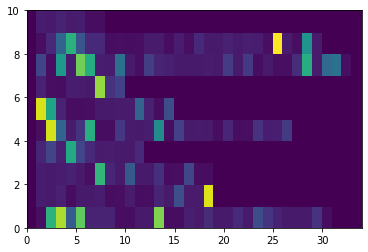

In [17]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=1)
_ = plt.pcolormesh(input_word_ids[:10].to_tensor())

In [18]:
lens = [len(i) for i in input_word_ids]

In [19]:
max_seq_length = max(lens)
print("Max length is", max_seq_length)

Max length is 100


In [20]:
max_seq_length = int(max_seq_length*1.5)
print("New max length is", max_seq_length)

New max length is 150


In [26]:
def encode_names(n, tokenizer):
    tokens = list(tokenizer.tokenize(n))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
    num_examples = len(string_list)
    
    string_tokens = tf.ragged.constant([
        encode_names(n, tokenizer) for n in np.array(string_list)
    ])
    
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
    input_word_ids = tf.concat([cls, string_tokens], axis=1)
    
    input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))
    
    type_cls = tf.zeros_like(cls)
    type_tokens = tf.ones_like(string_tokens)
    input_type_ids = tf.concat([type_cls, type_tokens], axis=1).to_tensor(shape=(None, max_seq_length))
    
    inputs = {
        'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }
    
    return inputs

In [27]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [32]:
print(X_train['input_word_ids'][0])
print(X_train['input_mask'][0])
print(X_train['input_type_ids'][0])

tf.Tensor(
[  101  1030 18804 25643  8458 22091  2860  2860  2860  1012  1012  2016
  2003 23677  1012  1012  2515  2016  3637  2012  1996  3329  1997  6737
  4364  2793  2030  2007  1996  4268  1029   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0], shape=(150,), dtype=int32)
tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [33]:
num_class = len(encoder.classes_)

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")

bert_input = {
    'input_word_ids': input_word_ids,
    'input_mask': input_mask,
    'input_type_ids': input_type_ids
}

outputs = bert_layer(bert_input)
pooled_output = outputs['pooled_output']

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)
output = tf.keras.layers.Dense(num_class, activation='softmax')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'default': (None, 2 9591041     input_mask[0][0]                 
                                                                 input_type_ids[0][0]         

In [67]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [36]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics='accuracy'
)

In [37]:
model.fit(
    X_train,
    dummy_y_train,
    epochs=2,
    verbose=1
)

Epoch 1/2
800/800 [==============================] - 1558s 2s/step - loss: 0.6225 - accuracy: 0.6727
Epoch 2/2
800/800 [==============================] - 1521s 2s/step - loss: 0.5846 - accuracy: 0.7018


In [57]:
y_pred = model.predict(X_test)     

In [58]:
all_arr = []

for i in range(0, len(y_pred)):
    pos = np.argmax(y_pred[i])
    arr = []
    for j in range(0, len(y_pred[i])):
        if j == pos:
            arr.append(1)
        else:
            arr.append(0)
    all_arr.append(arr)
    
#print(all_arr)

from sklearn.metrics import accuracy_score
print(accuracy_score(dummy_y_test,all_arr))

0.7071875


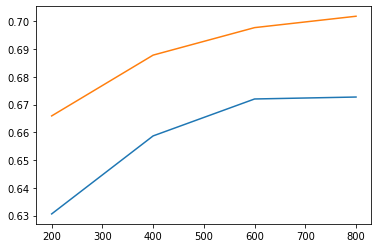

In [49]:
step_in_epoch = [200,400,600,800]
accuracy_epoch_1 = [0.6306,0.6587,0.6720,0.6727]
accuracy_epoch_2 = [0.6659,0.6878,0.6977,0.7018]

plt.plot(step_in_epoch, accuracy_epoch_1)
plt.plot(step_in_epoch, accuracy_epoch_2)
plt.show()

In [50]:
bert_layer_not = hub.KerasLayer(loaded_model, trainable=False)

In [51]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")

bert_input = {
    'input_word_ids': input_word_ids,
    'input_mask': input_mask,
    'input_type_ids': input_type_ids
}

outputs = bert_layer_not(bert_input)
pooled_output = outputs['pooled_output']

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)
output = tf.keras.layers.Dense(num_class, activation='softmax')(output)

model_nt = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output
)

model_nt.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'default': (None, 2 9591041     input_mask[0][0]                 
                                                                 input_type_ids[0][0]       

In [52]:
model_nt.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics='accuracy'
)

In [54]:
history = model_nt.fit(
    X_train,
    dummy_y_train,
    epochs=2,
    verbose=1
)

Epoch 1/2
800/800 [==============================] - 414s 499ms/step - loss: 0.5460 - accuracy: 0.7320
Epoch 2/2
800/800 [==============================] - 407s 508ms/step - loss: 0.5228 - accuracy: 0.7504


In [55]:
y_pred_nt = model_nt.predict(X_test)

In [56]:
all_arr = []

for i in range(0, len(y_pred_nt)):
    pos = np.argmax(y_pred_nt[i])
    arr = []
    for j in range(0, len(y_pred_nt[i])):
        if j == pos:
            arr.append(1)
        else:
            arr.append(0)
    all_arr.append(arr)
    
#print(all_arr)

from sklearn.metrics import accuracy_score
print(accuracy_score(dummy_y_test,all_arr))

0.7109375


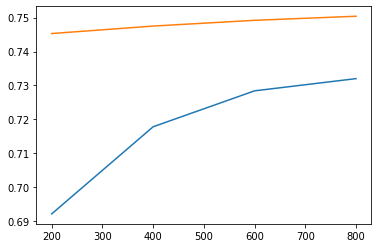

In [59]:
step_in_epoch = [200,400,600,800]
accuracy_epoch_1 = [0.6921,0.7178,0.7284,0.7320]
accuracy_epoch_2 = [0.7453,0.7475,0.7492,0.7504]

plt.plot(step_in_epoch, accuracy_epoch_1)
plt.plot(step_in_epoch, accuracy_epoch_2)
plt.show()

In [61]:
model.save('D:/my_saved_models/trainable_model')
model_nt.save('D:/my_saved_models/nontrainable_model')

INFO:tensorflow:Assets written to: D:/my_saved_models/trainable_model\assets


INFO:tensorflow:Assets written to: D:/my_saved_models/trainable_model\assets


INFO:tensorflow:Assets written to: D:/my_saved_models/nontrainable_model\assets


INFO:tensorflow:Assets written to: D:/my_saved_models/nontrainable_model\assets


In [63]:
import keras
my_trainable_saved_model = keras.models.load_model('D:/my_saved_models/trainable_model')
print(my_trainable_saved_model)

In [65]:
newSampleDf = df.sample(int(len(df)*0.01), random_state=23)

new_x = newSampleDf.text
new_y = newSampleDf.target

x_tokens = bert_encode(new_x, tokenizer, max_seq_length)
print(x_tokens)

{'input_word_ids': <tf.Tensor: shape=(16000, 150), dtype=int32, numpy=
array([[  101,  7483,  2001, ...,     0,     0,     0],
       [  101, 25430,  2546, ...,     0,     0,     0],
       [  101,  1030, 15090, ...,     0,     0,     0],
       ...,
       [  101,  2092,  2049, ...,     0,     0,     0],
       [  101,  1030, 22953, ...,     0,     0,     0],
       [  101,  2003, 17111, ...,     0,     0,     0]])>, 'input_mask': <tf.Tensor: shape=(16000, 150), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'input_type_ids': <tf.Tensor: shape=(16000, 150), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])>}


In [66]:
my_trainable_saved_model.predict(x_tokens)

array([[0.71814346, 0.28185654],
       [0.36146596, 0.638534  ],
       [0.44308925, 0.55691075],
       ...,
       [0.7280339 , 0.27196613],
       [0.44063917, 0.55936086],
       [0.7156173 , 0.28438267]], dtype=float32)